In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
%matplotlib inline 

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [4]:
train_csv = import_data('train.csv')
test_csv = import_data('test.csv')
meal = import_data('meal_info.csv')
center = import_data('center_info.csv')

Memory usage of dataframe is 31.35 MB
Memory usage after optimization is: 7.84 MB
Decreased by 75.0%
Memory usage of dataframe is 1.99 MB
Memory usage after optimization is: 0.50 MB
Decreased by 75.0%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 5.8%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 74.7%


In [5]:
def merging_data(data):
    merged_meal = pd.merge(data, meal, how='left', on='meal_id', sort=False)
    merged_center = pd.merge(merged_meal,center,how='left', on='center_id', sort=False)
    return merged_center

In [6]:
train = merging_data(train_csv)
test = merging_data(test_csv)

In [7]:
for df in [train, test]:
    df.drop('id', inplace=True, axis=1)

In [8]:
for col in ['center_id',
            'meal_id',
            'category',
            'cuisine',
            'city_code',
            'region_code',
            'center_type',
           'emailer_for_promotion',
           'homepage_featured',
           'op_area']:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [9]:
train.head(5)

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1,55,1885,136.875,152.250,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1,55,1993,136.875,135.875,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1,55,2539,134.875,135.875,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1,55,2139,339.500,437.500,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1,55,2631,243.500,242.500,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 14 columns):
week                     456548 non-null int16
center_id                456548 non-null category
meal_id                  456548 non-null category
checkout_price           456548 non-null float16
base_price               456548 non-null float16
emailer_for_promotion    456548 non-null category
homepage_featured        456548 non-null category
num_orders               456548 non-null int16
category                 456548 non-null category
cuisine                  456548 non-null category
city_code                456548 non-null category
region_code              456548 non-null category
center_type              456548 non-null category
op_area                  456548 non-null category
dtypes: category(10), float16(2), int16(2)
memory usage: 11.3 MB


In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=77)
train['price_cat'] = kmeans.fit_predict(train[['base_price', 'checkout_price']])

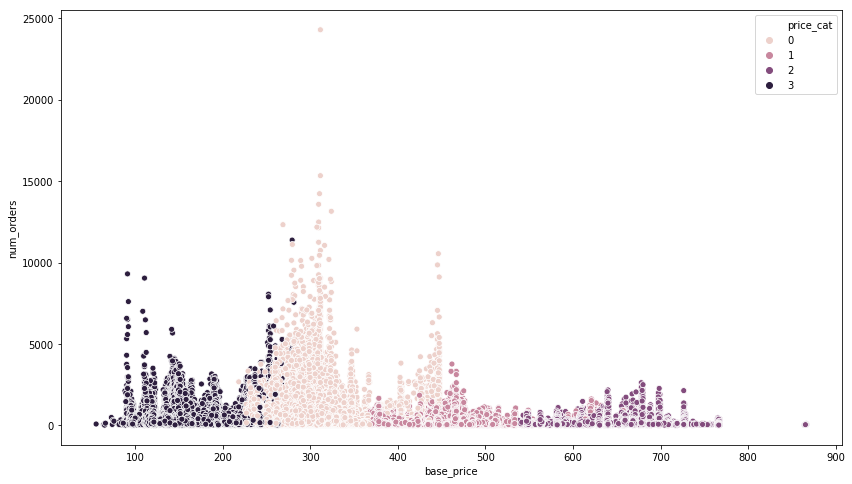

In [12]:
plt.figure(figsize=(14,8))
sns.scatterplot(y='num_orders', x='base_price', hue='price_cat', data=train)

In [13]:
train['discount'] = train['base_price'] - train['checkout_price']
train['discount_per'] = (train['base_price'] - train['checkout_price'])/train['base_price']
test['discount'] = test['base_price'] - test['checkout_price']
test['discount_per'] = (test['base_price'] - test['checkout_price'])/test['base_price']
train['price_cat'] = kmeans.fit_predict(train[['base_price', 'checkout_price']])
test['price_cat'] = kmeans.predict(test[['base_price', 'checkout_price']])
train['price_cat'] = train['price_cat'].astype('category')
test['price_cat'] = test['price_cat'].astype('category')

In [14]:
def category_plot(data, column):
    plt.style.use('ggplot')
    plt.figure(figsize=(16,10))
    plt.subplot(121)
    sns.boxplot(x=data[column], y=data['num_orders'])
    plt.xticks(rotation=75)
    plt.subplot(122)
    sns.countplot(data[column])
    plt.xticks(rotation=75)
    plt.suptitle(column)

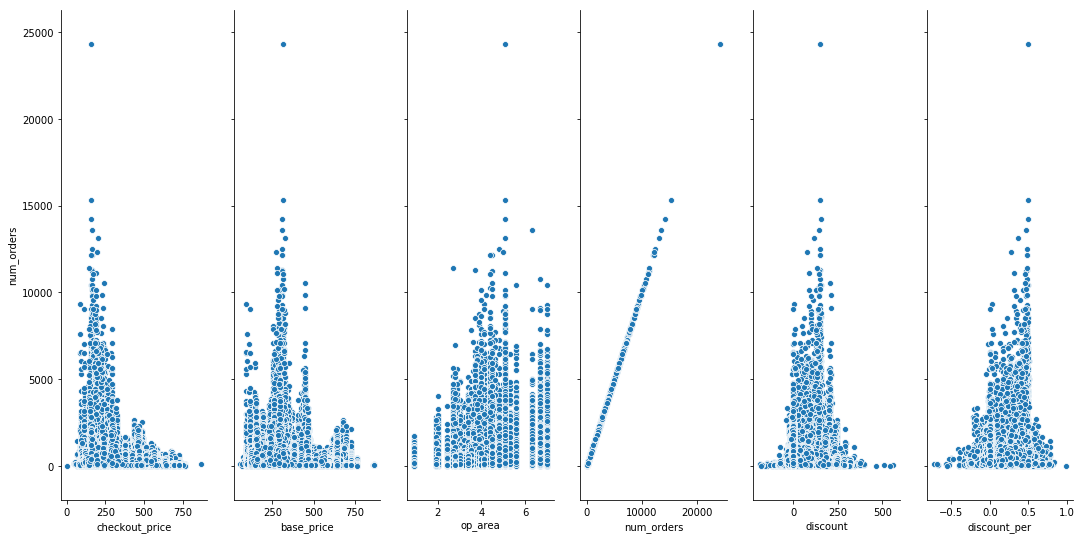

In [15]:
g = sns.pairplot(train, x_vars=['checkout_price', 'base_price', 'op_area', 'num_orders', 'discount', 'discount_per'],
                 y_vars=['num_orders'])
g.fig.set_size_inches(15,10)

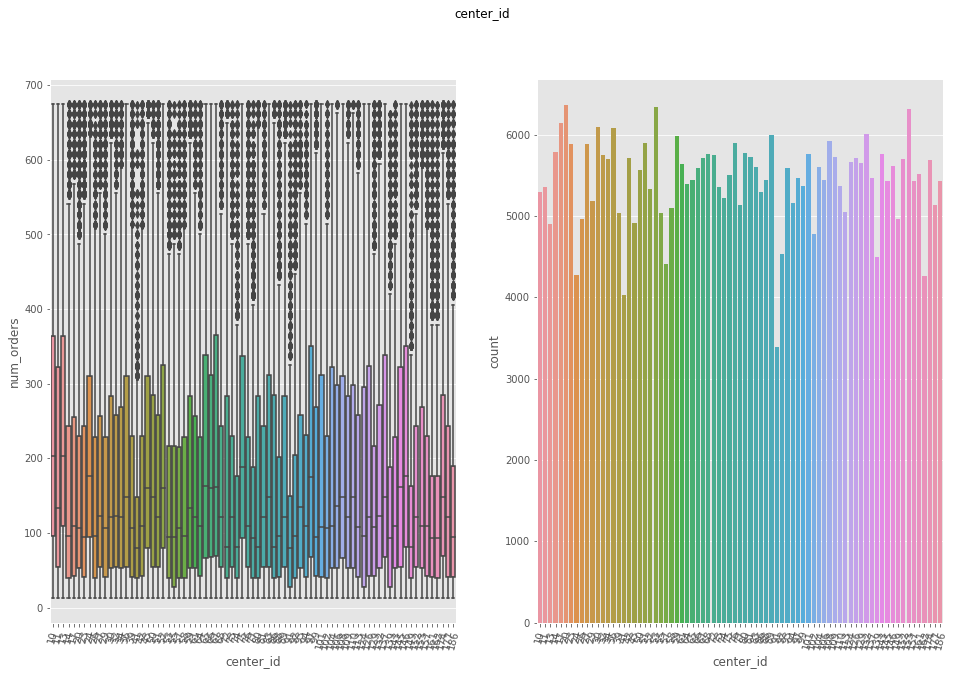

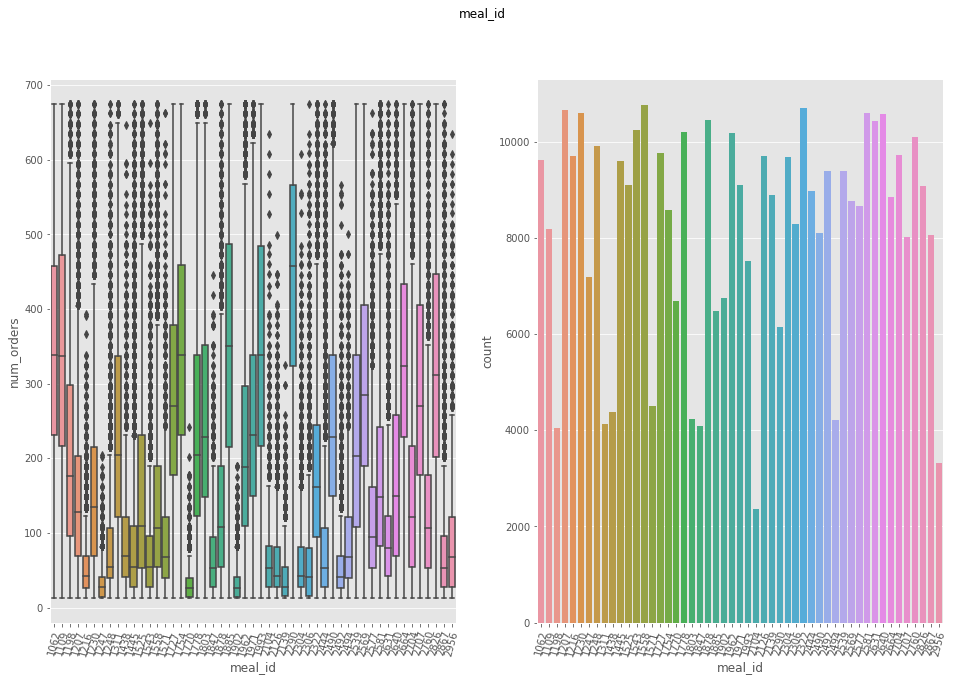

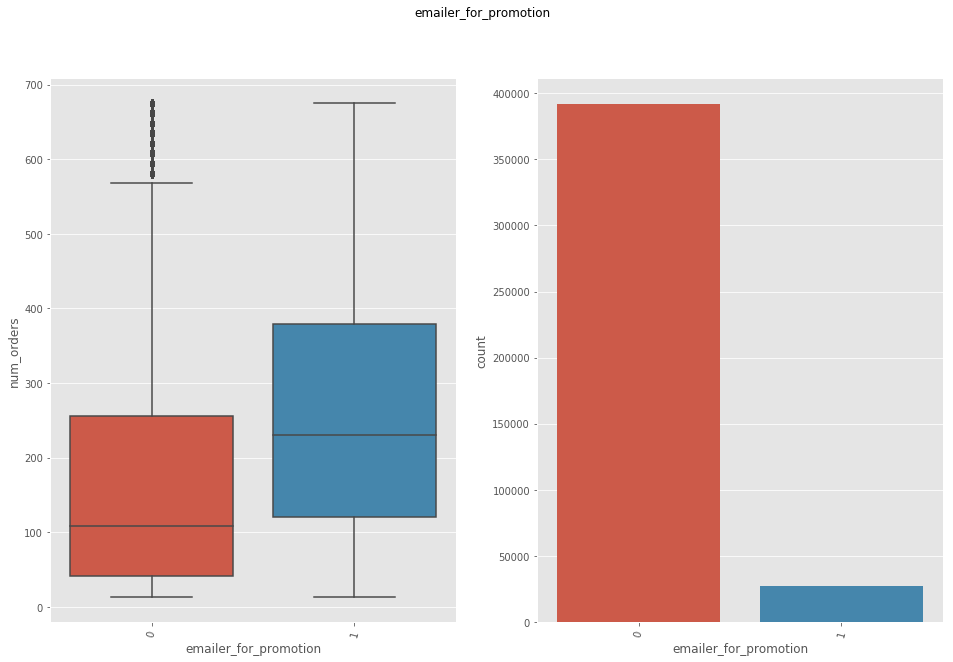

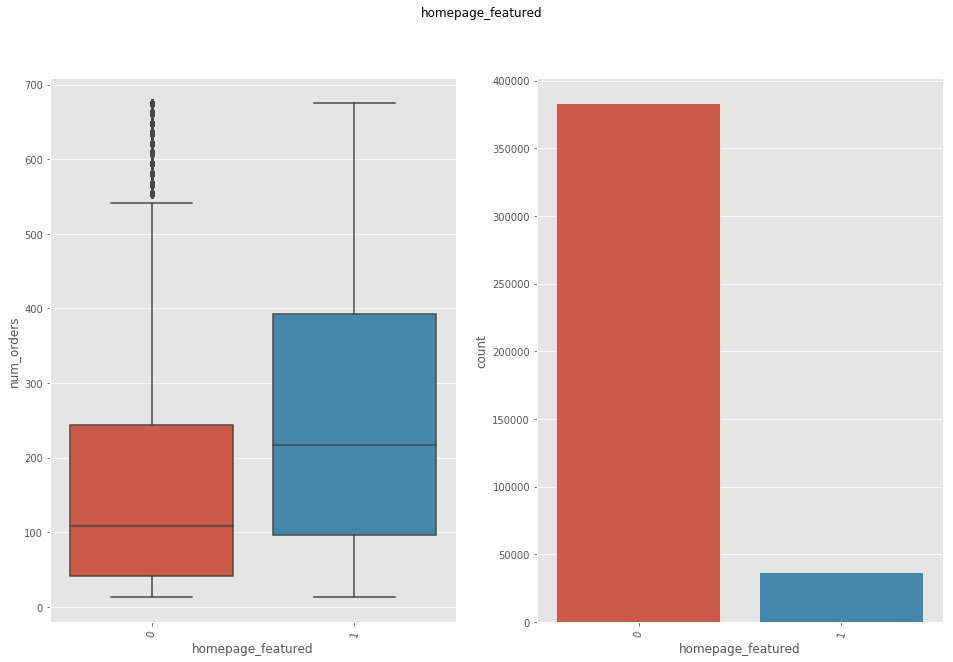

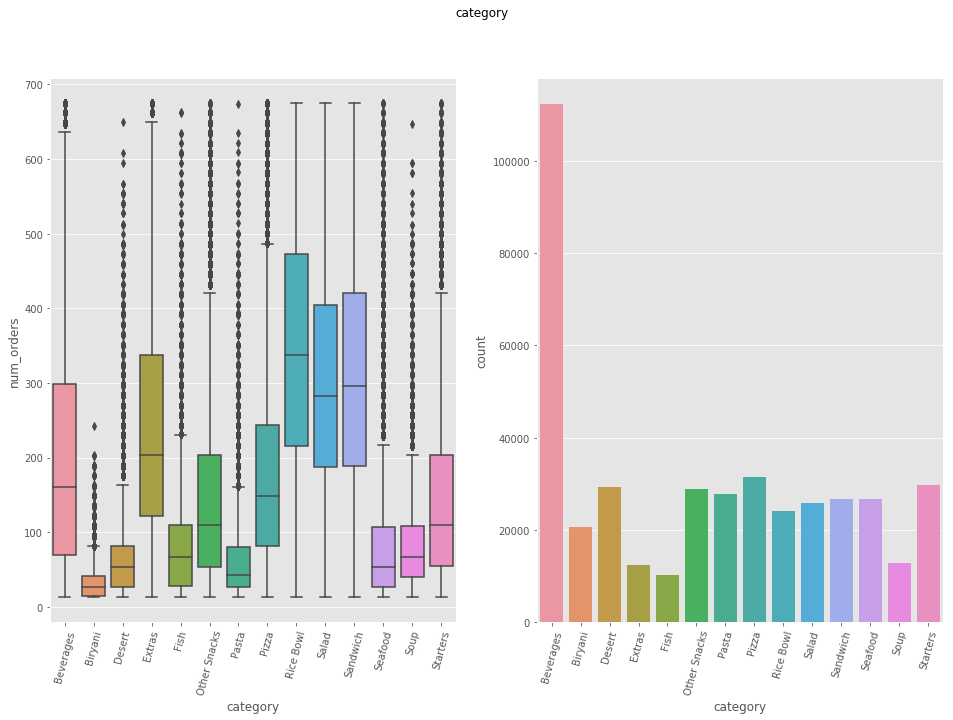

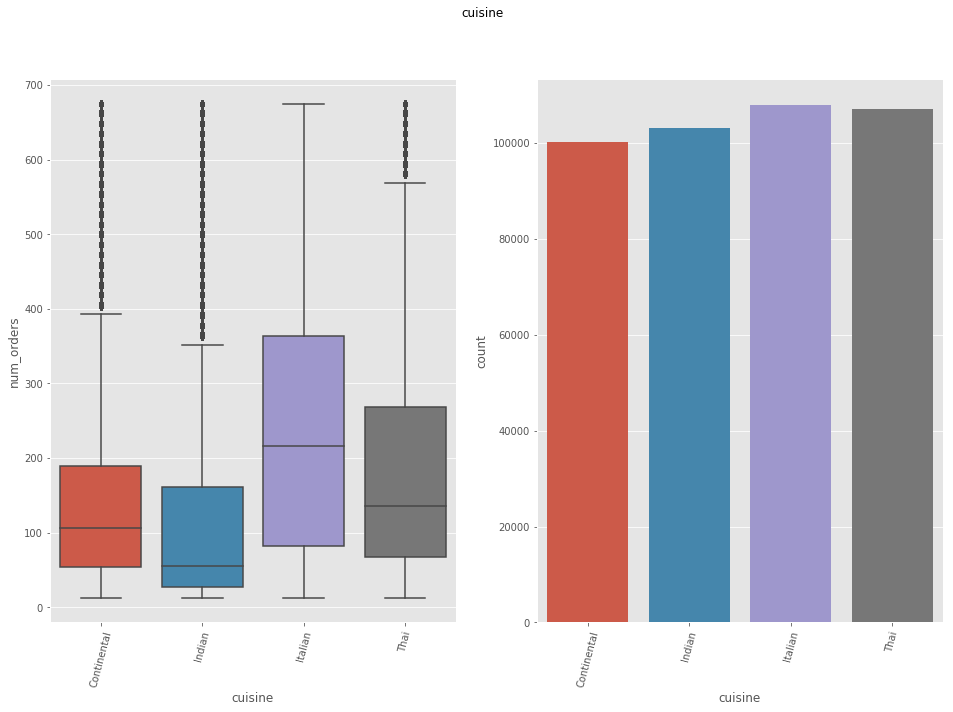

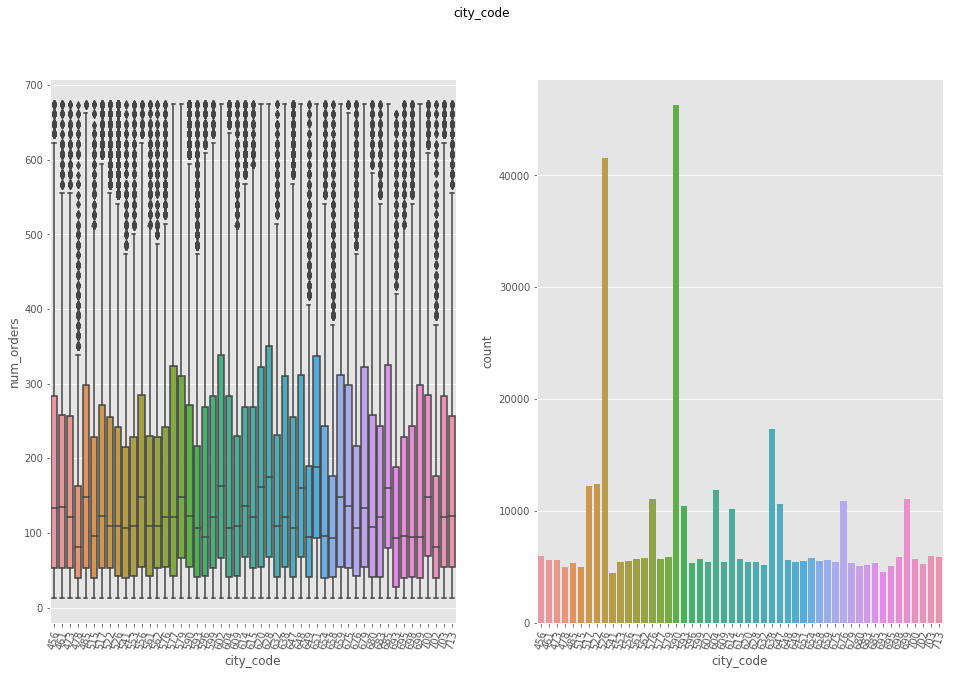

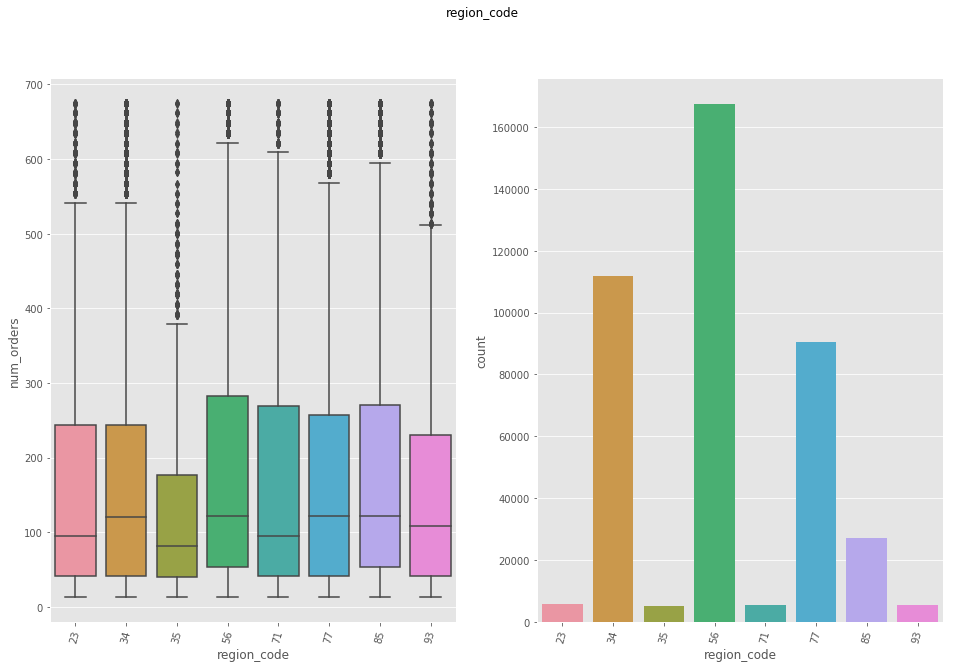

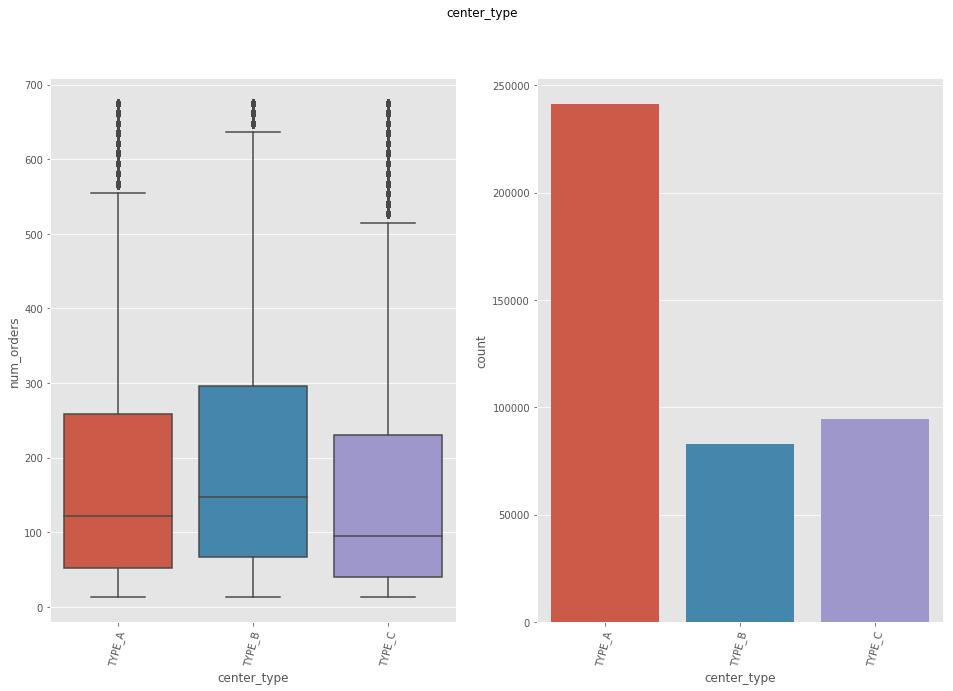

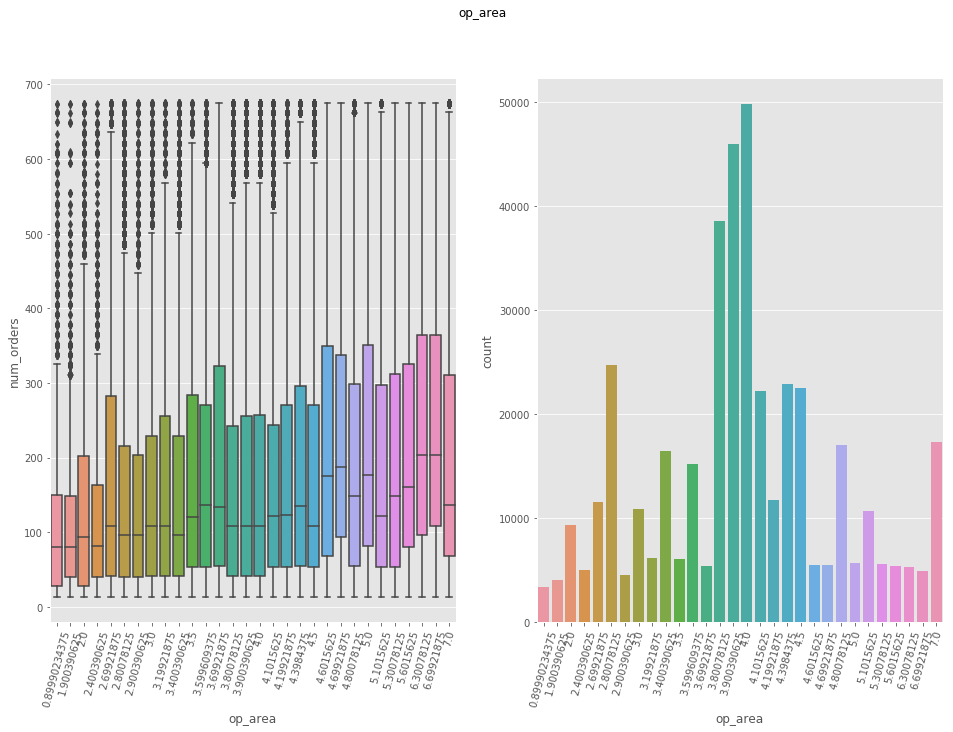

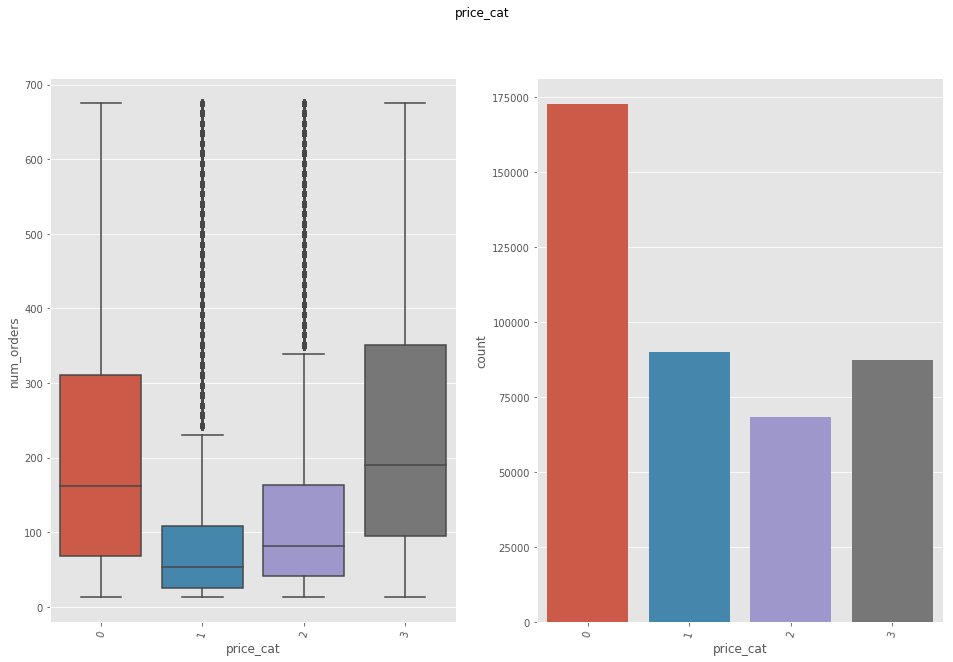

In [16]:
data = train[train['num_orders'] < 676]
cat_columns = train.select_dtypes(include='category')
for c in cat_columns:
    category_plot(data, c)

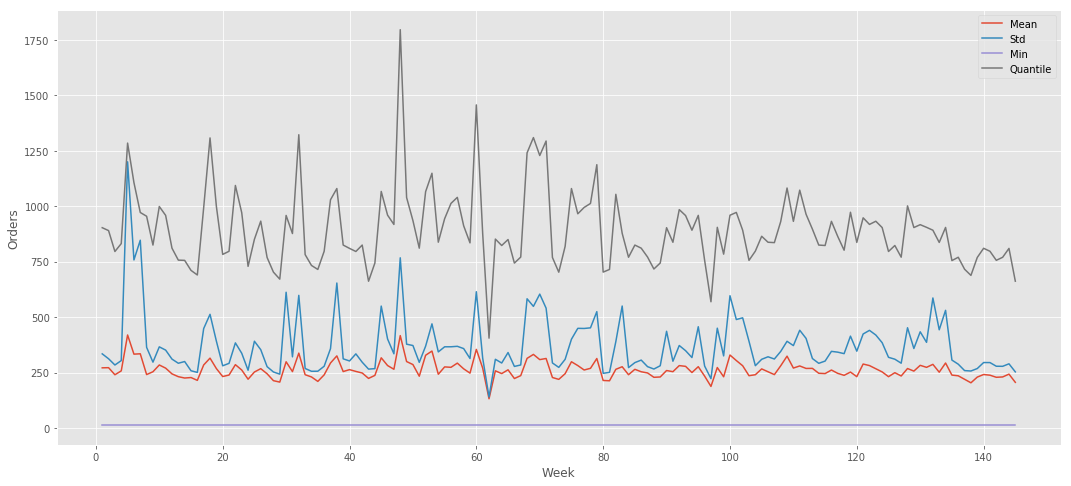

In [17]:
plot_week_mean = train.groupby('week')['num_orders'].mean()
plot_week_std = train.groupby('week')['num_orders'].std()
plot_week_max = train.groupby('week')['num_orders'].max()
plot_week_min = train.groupby('week')['num_orders'].min()
plot_week_quantile = train.groupby('week')['num_orders'].quantile(q=0.95)

plt.figure(figsize=(18,8))
plt.plot(plot_week_mean, label='Mean')
plt.plot(plot_week_std, label='Std')
#plt.plot(plot_week_max, label='Max')
plt.plot(plot_week_min, label='Min')
plt.plot(plot_week_quantile, label='Quantile')
plt.xlabel('Week')
plt.ylabel('Orders')
plt.legend()

95% observations is under: 243 num orders


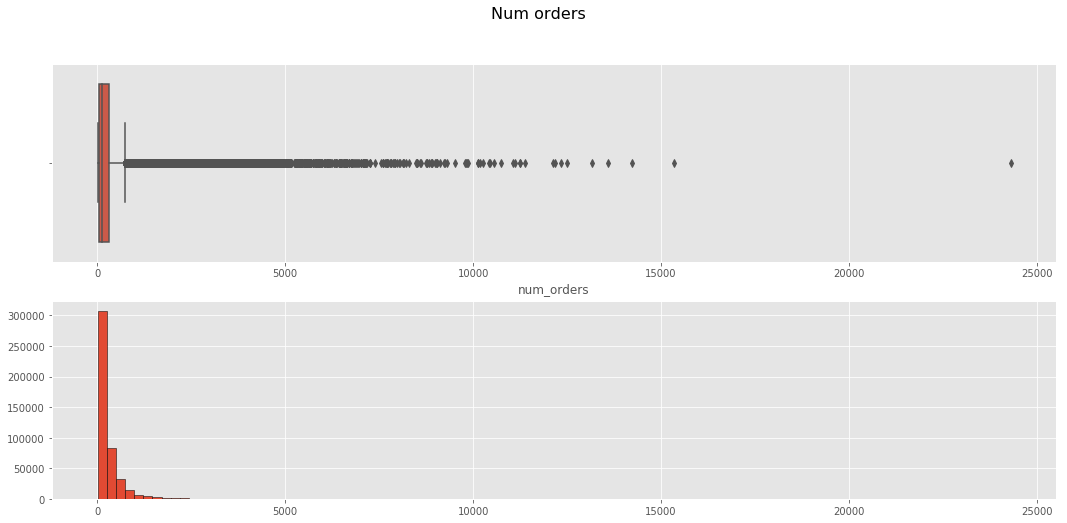

In [18]:
sort = train['num_orders'].sort_values()
ninety_percent = sort[int(sort.shape[0]*.95)]
print('95% observations is under:', ninety_percent, 'num orders')
f =plt.figure(figsize=(18,8))
plt.subplot(211)
sns.boxplot(train['num_orders'])
plt.subplot(212)
plt.hist(train['num_orders'], bins=100, edgecolor='black')
f.suptitle('Num orders', fontsize=16)
plt.show()

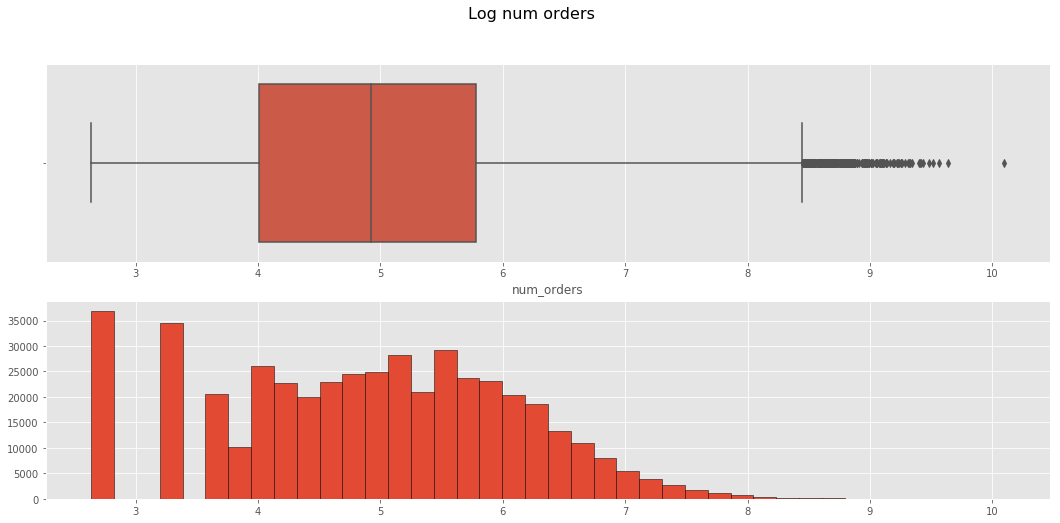

In [19]:
f =plt.figure(figsize=(18,8))
plt.subplot(211)
sns.boxplot(np.log1p(train['num_orders']))
plt.subplot(212)
plt.hist(np.log1p(train['num_orders']), bins=40, edgecolor='black')
f.suptitle('Log num orders', fontsize=16)
plt.show()

In [20]:
for df, text in zip([train, test], ['train', 'test']) :
    for cat in train.select_dtypes(include='category'):
        print(text, 'SET', cat, 'unique categories:', len(df[cat].value_counts()))

train SET center_id unique categories: 77
train SET meal_id unique categories: 51
train SET emailer_for_promotion unique categories: 2
train SET homepage_featured unique categories: 2
train SET category unique categories: 14
train SET cuisine unique categories: 4
train SET city_code unique categories: 51
train SET region_code unique categories: 8
train SET center_type unique categories: 3
train SET op_area unique categories: 30
train SET price_cat unique categories: 4
test SET center_id unique categories: 77
test SET meal_id unique categories: 51
test SET emailer_for_promotion unique categories: 2
test SET homepage_featured unique categories: 2
test SET category unique categories: 14
test SET cuisine unique categories: 4
test SET city_code unique categories: 51
test SET region_code unique categories: 8
test SET center_type unique categories: 3
test SET op_area unique categories: 30
test SET price_cat unique categories: 4


In [21]:
def prepare_data(train_sample, test_sample, columns_enc,val_sample, dummies=None):
    for col in columns_enc:
        group_avg = train_sample.groupby(col)['num_orders'].mean()
        group_std = train_sample.groupby(col)['num_orders'].std()
        group_max = train_sample.groupby(col)['num_orders'].max()
        #group_min = train_sample.groupby(col)['num_orders'].min()
        group_qua = train_sample.groupby(col)['num_orders'].quantile(q=0.95)
        ###
        train_sample.loc[:,col + '_avg_order'] = train_sample[col].map(group_avg)
        train_sample.loc[:,col + '_std_order'] = train_sample[col].map(group_std)
        train_sample.loc[:,col + '_max_order'] = train_sample[col].map(group_max)
        #train_sample.loc[:,col + '_min_order'] = train_sample[col].map(group_min)
        train_sample.loc[:,col + '_qua_order'] = train_sample[col].map(group_qua)
        test_sample.loc[:,col + '_avg_order'] = test_sample[col].map(group_avg)
        test_sample.loc[:,col + '_std_order'] = test_sample[col].map(group_std)
        test_sample.loc[:,col + '_max_order'] = test_sample[col].map(group_max)
        #test_sample.loc[:,col + '_min_order'] = test_sample[col].map(group_min)
        test_sample.loc[:,col + '_qua_order'] = test_sample[col].map(group_qua)
        val_sample.loc[:,col + '_avg_order'] = val_sample[col].map(group_avg)
        val_sample.loc[:,col + '_std_order'] = val_sample[col].map(group_std)
        val_sample.loc[:,col + '_max_order'] = val_sample[col].map(group_max)
        #val_sample.loc[:,col + '_min_order'] = val_sample[col].map(group_min)
        val_sample.loc[:,col + '_qua_order'] = val_sample[col].map(group_qua)
    #validate
    y_val = val_sample['num_orders']
    val_sample.drop(col_to_drop, axis=1,inplace=True)
    val_sample.drop(['num_orders'], axis=1, inplace=True)
    #trening
    y_train = train_sample['num_orders']
    train_sample.drop(col_to_drop, axis=1,inplace=True)
    train_sample.drop(['num_orders'], axis=1, inplace=True)
    #test
    test_sample.drop(col_to_drop, axis=1, inplace=True)
    if dummies:
        val_sample = pd.get_dummies(val_sample)
        train_sample = pd.get_dummies(train_sample)
        test_sample = pd.get_dummies(test_sample)
        
    return train_sample, val_sample, test_sample, y_train, y_val

In [22]:
data_train = train.copy()
data_test = test.copy()
#trening
train_sample = data_train[(data_train['week'] > 70) & (data_train['week'] < 136)]
#train_sample = data_train
#val
val_sample = data_train[data_train['week'] > 135]
#columns to mean encoding
columns_enc = ['center_id','meal_id','category','cuisine', 'city_code','region_code', 'center_type']
#columns_enc = ['center_id','meal_id','category','cuisine']
#columns to drop
col_to_drop = ['week','center_id', 'meal_id',
               'category','cuisine',
               'city_code','region_code', 'center_type']

In [23]:
trening, val, data_test, y_train, y_val = prepare_data(train_sample, data_test, columns_enc, val_sample, dummies=False)

C:\Data science\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Data science\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Data science\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [24]:
def my_rmse(y_test, y_pred):
   #return 100*(np.sqrt(np.mean((np.log(y_test+1) - np.log(y_pred+1))**2)))
    return np.sqrt(np.mean((np.log(y_test+1) - np.log(y_pred+1))**2))

def lgb_rmse(y_test, y_pred):
    return np.sqrt(mean_squared_log_error(y_test,y_pred))

def rmsle(y_true, y_pred):
    #return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False
    return 'RMSLE', np.sqrt(np.mean(np.power(y_pred - y_true, 2))), False

scorer = make_scorer(my_rmse, greater_is_better=False)
scorer_lgb = make_scorer(lgb_rmse, greater_is_better=False)

# MODELS

In [25]:
rf = RandomForestRegressor(n_estimators=200, max_depth=18)

In [26]:
lgb = LGBMRegressor(max_depth=18, learning_rate=0.1, n_estimators=4000, reg_alpha=5, reg_lambda=3 ,num_leaves=300, max_bin=400)

In [27]:
def run_model(model):
    model.fit(trening, y_train)
    train_pred = model.predict(trening)
    val_pred = model.predict(val)
    resid = y_val - val_pred
    resid = np.abs(resid)
    resid_train = y_train - train_pred
    print('RMSLE TRAIN:', my_rmse(y_train, train_pred))
    print('RMSLE VAL:', my_rmse(y_val, val_pred))
    plt.figure(figsize=(12,8))
    sc = plt.scatter(val_pred, y_val, alpha=1, c=resid, cmap='inferno')
    plt.colorbar(sc)
    plt.plot([min(val_pred),max(val_pred)], [min(val_pred),max(val_pred)], c="red")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show
    return model

In [28]:
def run_lgb(model):
    model.fit(trening, np.log(y_train), eval_set=(val, np.log(y_val)), eval_names='Validation set',
              eval_metric=rmsle, verbose=400, early_stopping_rounds=200,
              categorical_feature='auto')
    train_pred = model.predict(trening)
    val_pred = model.predict(val)
    resid = y_val - np.exp(val_pred)
    resid = np.abs(resid)
    resid_train = y_train - np.exp(train_pred)
    print('RMSLE TRAIN:', my_rmse(y_train, np.exp(train_pred)))
    print('RMSLE VAL:', my_rmse(y_val, np.exp(val_pred)))
    plt.figure(figsize=(12,8))
    sc = plt.scatter(np.exp(val_pred), y_val, alpha=1, c=resid, cmap='inferno')
    plt.colorbar(sc)
    plt.plot([min(np.exp(val_pred)),max(np.exp(val_pred))], [min(np.exp(val_pred)),max(np.exp(val_pred))], c="red")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show
    return model

# ESTIMATIONS

RMSLE TRAIN: 0.41054409862201063
RMSLE VAL: 0.5220491680393263


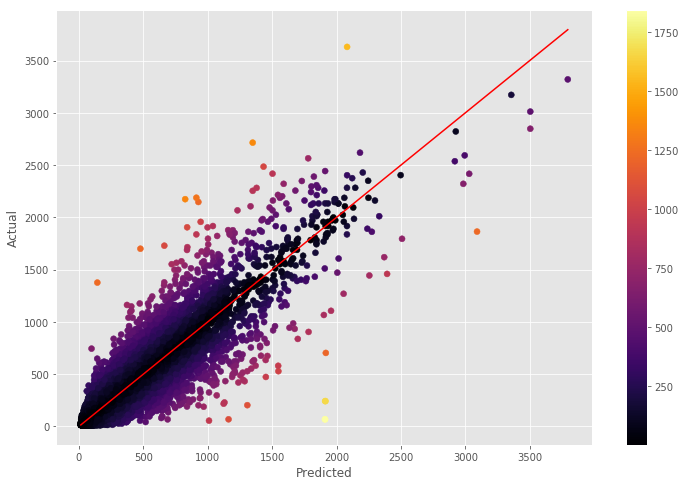

In [29]:
model = run_model(rf)

Training until validation scores don't improve for 200 rounds.
[400]	Validation set's l2: 0.259495	Validation set's RMSLE: 0.509407
Early stopping, best iteration is:
[219]	Validation set's l2: 0.25798	Validation set's RMSLE: 0.507917
RMSLE TRAIN: 0.4295840097775024
RMSLE VAL: 0.49852051382593077


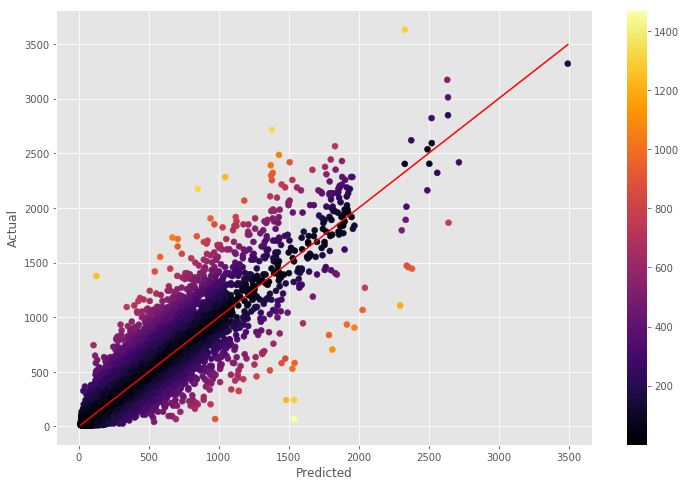

In [30]:
lgb_model = run_lgb(lgb)

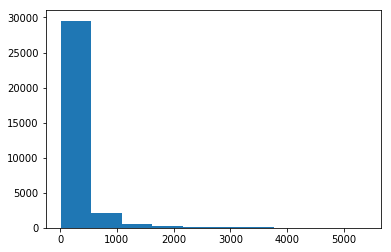

In [154]:
lgb_predict = lgb_model.predict(data_test)
lgb_predict = np.exp(lgb_predict)
#lgb_predict[lgb_predict<0] = 13
plt.hist(lgb_predict)
sample = pd.read_csv('submission.csv')
sample['num_orders'] = lgb_predict
sample.to_csv('submit.csv', index=False)

<function matplotlib.pyplot.show(*args, **kw)>

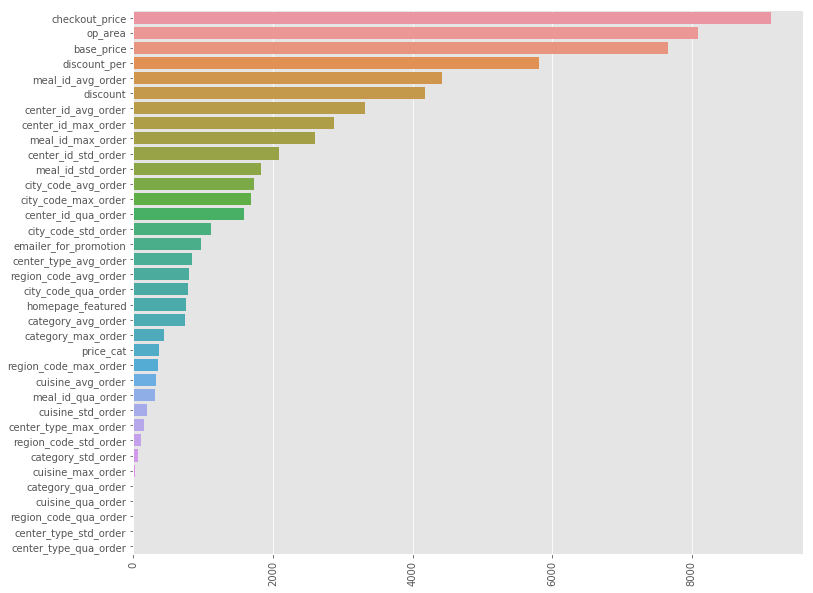

In [31]:
coef = pd.concat([pd.Series(lgb_model.feature_importances_), pd.Series(trening.columns)], axis=1)
coef.columns = ['importance', 'column']
coef = coef.sort_values(by='importance', ascending=False)
plt.figure(figsize=(12,10))
sns.barplot(x=lgb_model.feature_importances_, y=trening.columns, order=coef['column'])
plt.xticks(rotation=90)
plt.show

In [186]:
import shap

In [187]:
shap_values = shap.TreeExplainer(lgb_model).shap_values(val)

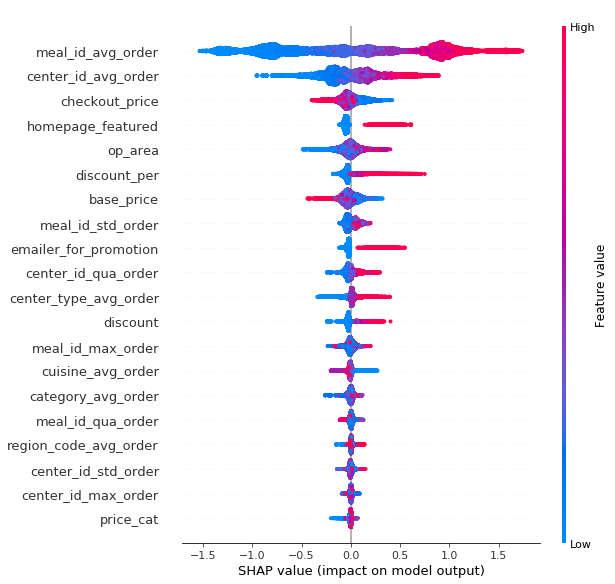

In [192]:
shap.summary_plot(shap_values, val)

In [42]:
rf.fit(trening, y_train)
predict = rf.predict(data_test)

In [80]:
predict = model.predict(data_test)

In [82]:
sample = pd.read_csv('submission.csv')
sample['num_orders'] = predict
sample.to_csv('submit.csv', index=False)